In [ ]:
import requests
from io import BytesIO
from zipfile import ZipFile
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import classification_report
from torchviz import make_dot


## Download the Dataset

In [ ]:
#Download the Dataset

dataset_link = 'https://universe.roboflow.com/ds/34oBZCp0Y9?key=M2AxU6iuig'
response = requests.get(dataset_link)
zip_file = ZipFile(BytesIO(response.content))

extracted_folder = '/dataset'
zip_file.extractall(extracted_folder)

## Pre-processing Dataset




In [ ]:
transform_train = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # using such random flips, helps to increase variability in your training data, which can prevent overfitting and improve the model's ability to generalize to unseen data
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

transform_test = transforms.Compose(
    [
         #all the images are currently 224 pixels but we can rezie later according to model accuracy to see if it makes any difference
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [ ]:
# Define object of the Train, Validation, and Test dataset.

train_dataset = torchvision.datasets.ImageFolder("/dataset/train", transform=transform_train)
train_dataset.transform

val_dataset = torchvision.datasets.ImageFolder("/dataset/valid", transform=transform_test)
val_dataset.transform

test_dataset = torchvision.datasets.ImageFolder("/dataset/test", transform=transform_test)
test_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Visualisation of Dataset

In [ ]:
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the validation dataset: {len(val_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")

Number of images in the training dataset: 2076
Number of images in the validation dataset: 531
Number of images in the test dataset: 231


In [ ]:
# Count the number of images per category in training dataset

train_category_count = {class_name: 0 for class_name in train_dataset.classes}

for _, label in train_dataset:
    class_name = train_dataset.classes[label]
    train_category_count[class_name] += 1

print("Training Dataset:")
for class_name, count in train_category_count.items():
    print(f"{class_name}: {count} images")

Training Dataset:
Mild: 217 images
Moderate: 563 images
No_DR: 1026 images
Proliferate_DR: 166 images
Severe: 104 images


In [ ]:
# Count the number of images per category in validation dataset

val_category_count = {class_name: 0 for class_name in val_dataset.classes}

for _, label in val_dataset:
    class_name = val_dataset.classes[label]
    val_category_count[class_name] += 1

print("Validation Dataset:")
for class_name, count in val_category_count.items():
    print(f"{class_name}: {count} images")

Validation Dataset:
Mild: 57 images
Moderate: 138 images
No_DR: 286 images
Proliferate_DR: 31 images
Severe: 19 images


In [ ]:
# Count the number of images per category in test dataset

test_category_count = {class_name: 0 for class_name in test_dataset.classes}

for _, label in test_dataset:
    class_name = test_dataset.classes[label]
    test_category_count[class_name] += 1

print("Test Dataset:")
for class_name, count in test_category_count.items():
    print(f"{class_name}: {count} images")

Test Dataset:
Mild: 20 images
Moderate: 65 images
No_DR: 118 images
Proliferate_DR: 20 images
Severe: 8 images


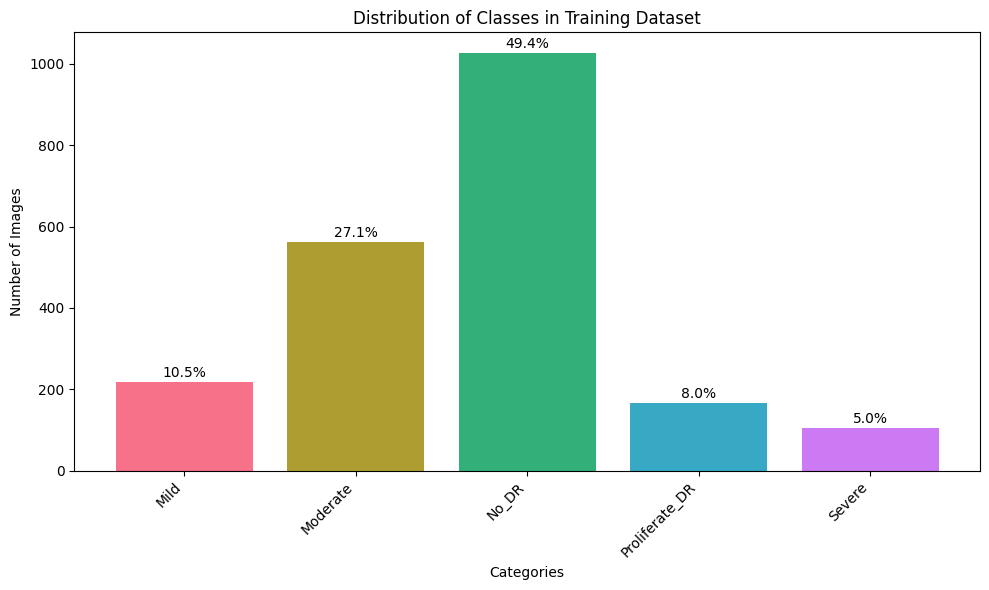

In [ ]:
# Function to plot class distribution bar graph

def plot_bar_graph(category_count, dataset_name):
    categories = list(category_count.keys())
    counts = list(category_count.values())
    total_count = sum(counts)
    percentages = [count / total_count * 100 for count in counts]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, counts, color=sns.color_palette("husl", len(categories)))
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title(f'Distribution of Classes in {dataset_name} Dataset')
    plt.xticks(rotation=45, ha='right')

    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
                 f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Plot bar graph for training dataset
plot_bar_graph(train_category_count, 'Training')

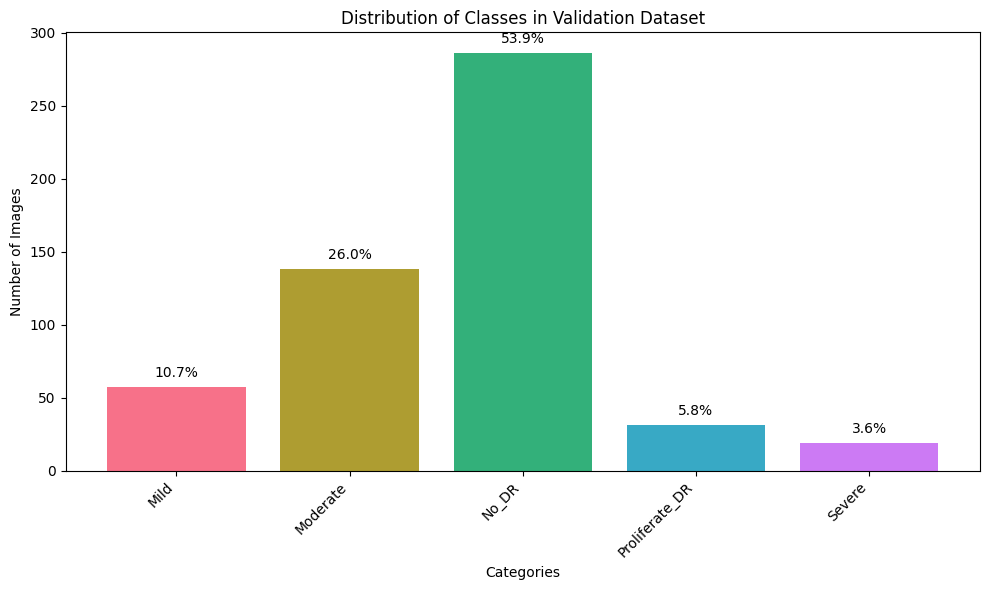

In [ ]:
plot_bar_graph(val_category_count, 'Validation')

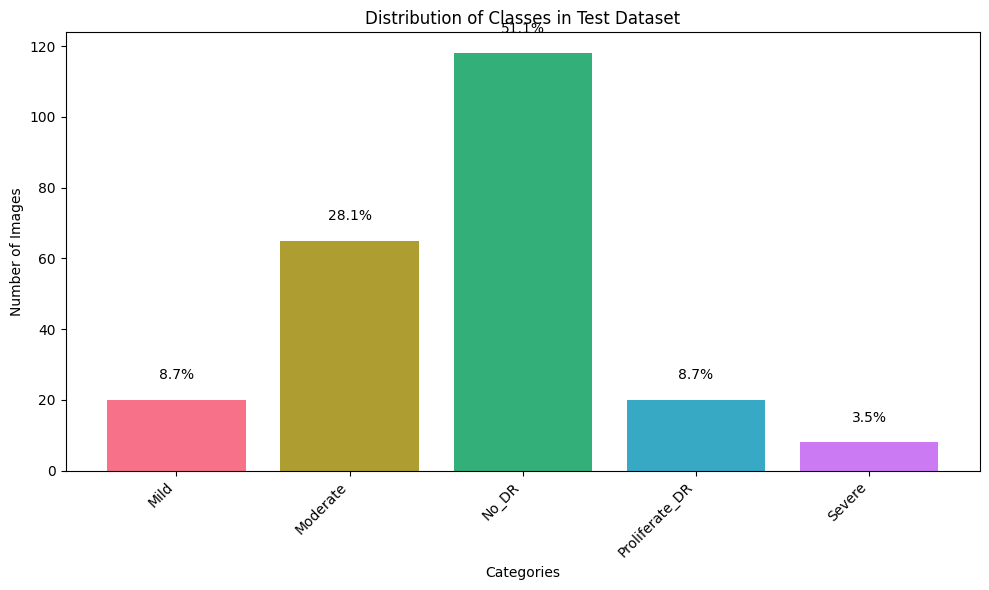

In [ ]:
# Plot bar graph for test dataset
plot_bar_graph(test_category_count, 'Test')

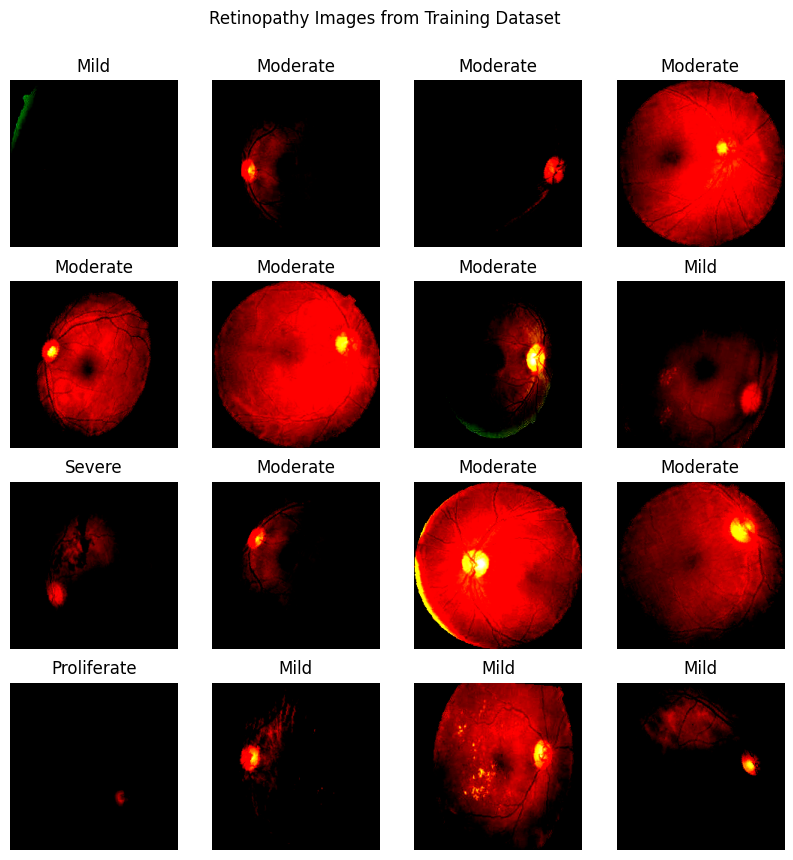

In [ ]:
#Visualise the images in the Training Dataset

CLA_label = {
        0 : 'No_DR',
        1 : 'Mild',
        2 : 'Moderate',
        3 : 'Proliferate',
        4 : 'Severe'
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images from Training Dataset', y=0.95)

plt.show()